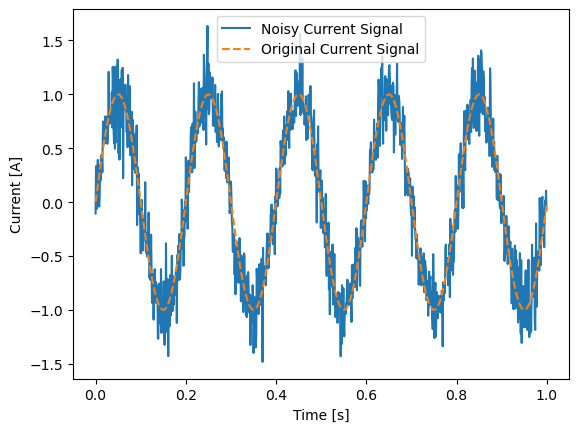

Dataset saved as 'synthetic_current_dataset.csv'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters for the signal
sampling_rate = 1000  # Sampling rate in Hz
duration = 1.0  # Duration in seconds
frequency = 5  # Frequency of the sinusoidal signal in Hz
amplitude = 1.0  # Amplitude of the signal

# Generate the time axis
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Generate the sinusoidal current signal
current_signal = amplitude * np.sin(2 * np.pi * frequency * t)

# Add some noise to the current signal
noise = 0.2 * np.random.normal(size=current_signal.shape)
noisy_current_signal = current_signal + noise

# Plot the current signal
plt.plot(t, noisy_current_signal, label='Noisy Current Signal')
plt.plot(t, current_signal, label='Original Current Signal', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Current [A]')
plt.legend()
plt.show()

# Create a DataFrame to store the dataset
data = pd.DataFrame({'Time': t, 'Current': noisy_current_signal})

# Save the dataset to a CSV file
data.to_csv('synthetic_current_dataset.csv', index=False)

print("Dataset saved as 'synthetic_current_dataset.csv'")


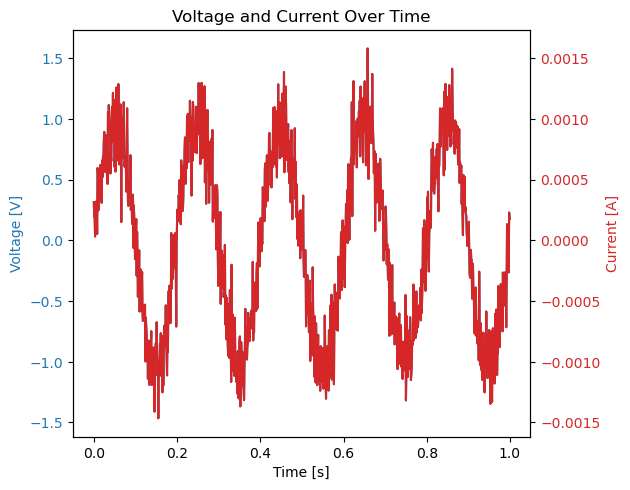

Updated dataset saved as 'voltage_and_current_dataset.csv'


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('synthetic_signal_dataset.csv')

# Parameters
resistance = 1000  # Resistance in ohms

# Extract time and voltage from the dataset
time = data['Time']
voltage = data['Signal']

# Calculate the current using Ohm's Law: I = V / R
current = voltage / resistance

# Plot the voltage and current
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]', color='tab:blue')
ax1.plot(time, voltage, color='tab:blue', label='Voltage')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Current [A]', color='tab:red')
ax2.plot(time, current, color='tab:red', label='Current')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Voltage and Current Over Time')
plt.show()

# Save the new dataset with voltage and current
data['Current'] = current
data.to_csv('voltage_and_current_dataset.csv', index=False)

print("Updated dataset saved as 'voltage_and_current_dataset.csv'")


Fault detection

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [4]:
data = pd.read_csv('classData.csv')

# Display the first few rows of the dataset
print("First few rows of the dataset:")
data.head()

First few rows of the dataset:


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [5]:
# Checking for missing values
print("\nChecking for missing values:")
missing_values = data.isnull().sum()

# Checking for any duplicates
duplicate_rows = data.duplicated().sum()

missing_values,duplicate_rows


Checking for missing values:


(G     0
 C     0
 B     0
 A     0
 Ia    0
 Ib    0
 Ic    0
 Va    0
 Vb    0
 Vc    0
 dtype: int64,
 0)

In [6]:
# Converting the fault indicator columns to a single label representing the type of fault
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = data['Fault_Type'].value_counts()
fault_type_counts


Fault_Type
No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: count, dtype: int64

C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Dell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating ins

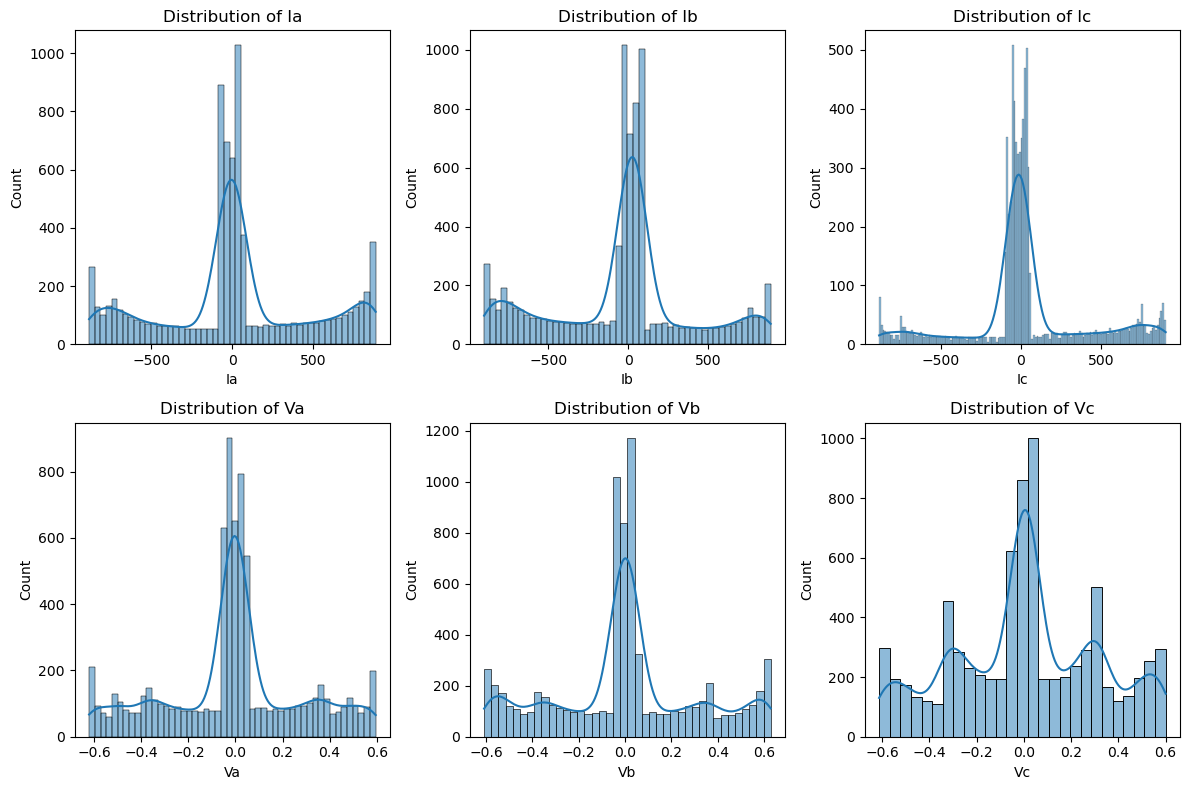

In [7]:
# Data Visualization: Histograms for each feature
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
plt.figure(figsize=(12, 8))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [8]:
data[features]

,Ia,Ib,Ic,Va,Vb,Vc
0,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983
...,...,...,...,...,...,...
7856,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598
7857,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407
7858,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104
7859,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690


In [9]:
data['Fault_Type']

0       Line-to-Line AB
1       Line-to-Line AB
2       Line-to-Line AB
3       Line-to-Line AB
4       Line-to-Line AB
             ...       
7856           No Fault
7857           No Fault
7858           No Fault
7859           No Fault
7860           No Fault
Name: Fault_Type, Length: 7861, dtype: object

In [10]:
data.describe()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,0.432006,0.411271,0.555527,0.571429,13.721194,-44.845268,34.392394,-0.007667,0.001152,0.006515
std,0.495387,0.492095,0.496939,0.494903,464.741671,439.269195,371.107412,0.289150,0.313437,0.307897
min,0.000000,0.000000,0.000000,0.000000,-883.542316,-900.526951,-883.357762,-0.620748,-0.608016,-0.612709
25%,0.000000,0.000000,0.000000,0.000000,-119.802518,-271.845947,-61.034219,-0.130287,-0.159507,-0.215977
50%,0.000000,0.000000,1.000000,1.000000,2.042805,5.513317,-4.326711,-0.005290,0.001620,0.009281
75%,1.000000,1.000000,1.000000,1.000000,227.246377,91.194282,49.115141,0.111627,0.153507,0.239973
max,1.000000,1.000000,1.000000,1.000000,885.738571,889.868884,901.274261,0.595342,0.627875,0.600179


In [11]:
data['Fault_Type'] = data['G'].astype('str') + data['C'].astype('str') + data['B'].astype('str') + data['A'].astype('str')
data.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


In [12]:
data.sample(10).style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
6067,0,0,0,0,44.541160,38.370941,-86.318836,-0.221882,0.617912,-0.396030,0000
3125,0,1,1,0,54.490973,-560.515574,508.543571,0.212223,0.031517,-0.243740,0110
4312,0,1,1,1,611.831049,-604.102560,-5.610430,0.024303,-0.441500,0.417197,0111
820,1,0,0,1,-848.285887,-62.877532,11.132332,0.154268,0.056248,-0.210516,1001
2549,0,1,1,0,-56.826511,727.866748,-668.486567,-0.036063,-0.018873,0.054935,0110
5330,1,1,1,1,403.948591,-882.763159,478.812305,-0.024413,-0.017753,0.042167,1111
6921,0,0,0,0,1.645907,82.212114,-86.996362,-0.577495,0.492848,0.084647,0000
1938,1,0,1,1,-789.578513,734.950111,11.600645,-0.001961,0.167290,-0.165329,1011
2226,1,0,1,1,519.989541,18.565721,32.048225,0.239716,-0.544166,0.304450,1011
682,1,0,0,1,663.616899,8.445452,33.998846,0.203006,-0.530594,0.327588,1001


In [13]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Fault_Type'] = encoder.fit_transform(data['Fault_Type'])
data['Fault_Type']

0       3
1       3
2       3
3       3
4       3
       ..
7856    0
7857    0
7858    0
7859    0
7860    0
Name: Fault_Type, Length: 7861, dtype: int32

In [14]:
# Assuming you have previously encoded the 'Fault_Type' column using label encoding
encoded_labels = data['Fault_Type']

# Get the unique classes from the label encoder
unique_classes = encoder.classes_
unique_classes

array(['0000', '0110', '0111', '1001', '1011', '1111'], dtype=object)

In [15]:
data['Fault_Type']

0       3
1       3
2       3
3       3
4       3
       ..
7856    0
7857    0
7858    0
7859    0
7860    0
Name: Fault_Type, Length: 7861, dtype: int32

In [16]:
X = data.drop(['Fault_Type','G','C','B','A'],axis=1)
y = data['Fault_Type']

In [17]:
data


,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3
...,...,...,...,...,...,...,...,...,...,...,...
7856,0,0,0,0,-66.237921,38.457041,24.912239,0.094421,-0.552019,0.457598,0
7857,0,0,0,0,-65.849493,37.465454,25.515675,0.103778,-0.555186,0.451407,0
7858,0,0,0,0,-65.446698,36.472055,26.106554,0.113107,-0.558211,0.445104,0
7859,0,0,0,0,-65.029633,35.477088,26.684731,0.122404,-0.561094,0.438690,0


In [18]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=21)

In [19]:
y_train

5472    5
6672    0
1373    4
3214    1
3290    2
       ..
48      3
772     3
5944    0
5327    5
7113    0
Name: Fault_Type, Length: 6288, dtype: int32

In [20]:
import xgboost as Xgb
xgb = Xgb.XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb = xgb.predict(X_test)
xgb.score(X_train, y_train)

xgb_train = round(xgb.score(X_train, y_train) * 100, 2)
xgb_accuracy = round(accuracy_score(y_pred_xgb, y_test) * 100, 2)

print("Training Accuracy    :",xgb_train ,"%")
print("Model Accuracy Score :",xgb_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_xgb))
print("\033[1m--------------------------------------------------------\033[0m")


Training Accuracy    : 92.94 %
Model Accuracy Score : 81.75 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       456
           1       1.00      1.00      1.00       198
           2       0.32      0.31      0.32       213
           3       1.00      1.00      1.00       227
           4       1.00      1.00      1.00       248
           5       0.38      0.40      0.39       231

    accuracy                           0.82      1573
   macro avg       0.78      0.78      0.78      1573
weighted avg       0.82      0.82      0.82      1573

--------------------------------------------------------


In [21]:
-66.237921	38.457041	24.912239	0.094421	-0.552019	0.457598

SyntaxError: invalid syntax (3433406694.py, line 1)

In [22]:
# Let's say you have new input values for prediction
new_input = {
     'Ia': -66.237921,
    'Ib': 38.457041,
    'Ic': 24.912239,
    'Va': 0.094421,
    'Vb': -0.552019,
    'Vc': 0.457598
}

# Convert the input dictionary into a DataFrame
new_input_df = pd.DataFrame([new_input])

# Make predictions using the trained model
predicted_fault_type = xgb.predict(new_input_df)

# Print the predicted fault type
print("Predicted Fault Type:", predicted_fault_type[0])

Predicted Fault Type: 0


In [23]:
# Define the mapping between text labels and integer values
label_mapping = {
    0:'NO Fault',
    1:'Line A to Ground Fault',
    2:'Line B to Line C Fault',
    3:'Line A Line B to Ground Fault',
    4:'Line A Line B Line C',
    5:'Line A Line B Line C to Ground Fault'
}

In [24]:

import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(xgb) 
  


In [25]:
label_mapping[predicted_fault_type[0]]

'NO Fault'

In [26]:
pickle.dump(xgb, open('model.pkl', 'wb'))

In [27]:
pickled_model = pickle.load(open('model.pkl', 'rb'))

In [28]:
# Let's say you have new input values for prediction
new_input = {
     'Ia': -66.237921,
    'Ib': 38.457041,
    'Ic': 24.912239,
    'Va': 0.094421,
    'Vb': -0.552019,
    'Vc': 0.457598
}

# Convert the input dictionary into a DataFrame
new_input_df = pd.DataFrame([new_input])

# Make predictions using the trained model
predicted_fault_type = pickled_model.predict(new_input_df)

# Print the predicted fault type
print("Predicted Fault Type:", predicted_fault_type[0])

Predicted Fault Type: 0


In [29]:
# Define the mapping between text labels and integer values
label_mapping = {
    0:'NO Fault',
    1:'Line A to Ground Fault',
    2:'Line B to Line C Fault',
    3:'Line A Line B to Ground Fault',
    4:'Line A Line B Line C',
    5:'Line A Line B Line C to Ground Fault'
}

In [30]:
label_mapping[predicted_fault_type[0]]

'NO Fault'